✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
{'question': ['the', 'vatican', 'apostolic', 'library', '(', ')', ',', 'more', 'commonly', 'called', 'the', 'vatican', 'library', 'or', 'simply', 'the', 'vat', ',', 'is', 'the', 'library', 'of', 'the', 'holy', 'see', ',', 'located', 'in', 'vatican', 'city', '.', 'formally', 'established', 'in', '1475', ',', 'although', 'it', 'is', 'much', 'older', ',', 'it', 'is', 'one', 'of', 'the', 'oldest', 'libraries', 'in', 'the', 'world', 'and', 'contains', 'one', 'of', 'the', 'most', 'significant', 'collections', 'of', 'historical', 'texts', '.', 'it', 'has', '75,000', 'codices', 'from', 'throughout', 'history', ',', 'as', 'well', 'as', '1.1', 'million', 'printed', 'books', ',', 'which', 'include', 'some', '8,500', 'incun

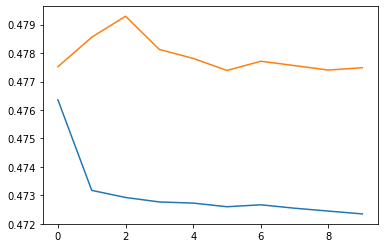

In [ ]:
# We need to first install the following facilities
!pip install --upgrade pip 
!pip install -U d2l
!pip install mxnet
!pip install torchtext
!python -m spacy download en

# Import libraries
import torch
import torchtext
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
import json
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import urllib.request
from torchtext.data import Field, BucketIterator, TabularDataset
import spacy 
import matplotlib.pyplot as plt
import numpy as np
import d2l
from d2l import mxnet as d2l 
from mxnet import np, npx
npx.set_np()

from urllib.parse import urlparse

# Set constants
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")


SEED = 101

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


# download the coqa files and cache them. 
# 
def _get_filename_from_url(url):
    parse = urlparse(url)
    return os.path.basename(parse.path)

def download_file(url, directory, filename=None, extension=None):
    if filename is None:
        filename = _get_filename_from_url(url)

    directory = str(directory)
    filepath = os.path.join(directory, filename)

    if not os.path.isdir(directory):
        os.makedirs(directory)

    # Download
    urllib.request.urlretrieve(url, filename=filepath)

    return filepath


def cache_coqa_dataset(directory='data/',
                  train=False,
                  dev=False,
                  train_filename='coqa-train-v1.0.json',
                  dev_filename='coqa-dev-v1.0.json',
                  url_train='https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json',
                  url_dev='https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json'):
    
    download_file(url=url_dev, directory=directory)
    download_file(url=url_train, directory=directory)

    ret = []
    splits = [(train, train_filename), (dev, dev_filename)]
    splits = [f for (requested, f) in splits if requested]
    for filename in splits:
        full_path = os.path.join(directory, filename)
        with open(full_path, 'r') as temp:
            ret.append(json.load(temp)['data'])

    if len(ret) == 1:
        return ret[0]
    else:
        return tuple(ret)


# Load the data from memory. Split to train and dev
train, dev = cache_coqa_dataset(train=True), cache_coqa_dataset(dev=True)

def extract_sentence_pairs(data):
  ret = []
  N_HISTORY = 2

  for record in data:
    history = [] 
    context_txt = record['story'] + ' || ' # The entire context

    # Find the history of the query 
    for query, ans in zip(record["questions"], record["answers"]):
        query_txt, ans_txt = query["input_text"], ans["input_text"]
        query_id, ans_id = query["turn_id"], ans["turn_id"]
        assert query_id == ans_id 
        history_len = min(len(history), N_HISTORY)

        for q, a in history[-history_len:]:
            context_txt += ' [Q] ' + q + ' [A] '  + a
        
        history.append((query_txt, ans_txt))
        context_txt += ' [Q] ' + query_txt
        ret.append((context_txt,  ans_txt))

  return ret

# Load the data into memory 
train_pairs, dev_pairs = extract_sentence_pairs(train), extract_sentence_pairs(dev)

# Preprecessing
def json_to_tsv(pairs, train = True):# Define path to new file
  filename = "train.txt" if train else "dev.txt"
  datafile = os.path.join("data", filename)

  delimiter = '\t'
  # Unescape the delimiter
  delimiter = str(codecs.decode(delimiter, "unicode_escape"))

  # Write new tab-seperated file
  with open(datafile, 'w', encoding='utf-8') as outputfile:
      writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
      for pair in pairs:
          writer.writerow(pair)

json_to_tsv(train_pairs)
json_to_tsv(dev_pairs, train = False)



spacy_en = spacy.load('en')

QUESTION = Field(tokenize="spacy", init_token = '<sos>', 
            eos_token = '<eos>', lower=True)
ANSWER = Field(tokenize= "spacy", init_token = '<sos>', 
            eos_token = '<eos>', lower=True)
fields = [('question', QUESTION), ('answer', ANSWER)]

train_data, dev_data = TabularDataset.splits(
                                        path = './data',
                                        train = 'train.txt',
                                        validation = 'dev.txt',
                                        format = 'tsv',
                                        fields = fields,
                                        skip_header = False
                                        )

print(vars(train_data[0]))

# Build the vocabulary
QUESTION.build_vocab()
ANSWER.build_vocab()

#*****************
# Modeling 
#*****************
BATCH_SIZE = 64

train_iterator, dev_iterator = BucketIterator.splits(
    (train_data, dev_data),
    sort = False, #don't sort test/validation data
    batch_size=BATCH_SIZE,
    device=device)

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

INPUT_DIM = len(QUESTION.vocab)
OUTPUT_DIM = len(ANSWER.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = ANSWER.vocab.stoi[ANSWER.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.question
        trg = batch.answer
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.question
            trg = batch.answer

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10
CLIP = 1

best_dev_loss = float('inf')
train_losses = []
dev_losses  = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    dev_loss = evaluate(model, dev_iterator, criterion)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        torch.save(model.state_dict(), 's2s-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.5f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Dev. Loss: {dev_loss:.5f} |  Dev. PPL: {math.exp(dev_loss):7.3f}')

# Plot the losses 

x = np.arange(1,11)
train_losses = np.array(train_losses)
dev_losses = np.array(dev_losses)
d2l.plot(x, [train_losses, dev_losses], xlabel= "epochs", ylabel= "loss", legend=["Train Loss", "Dev Loss"])

Requirement already up-to-date: d2l in /usr/local/lib/python3.6/dist-packages (0.14.4)
     |████████████████████████████████| 55.0MB 110kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


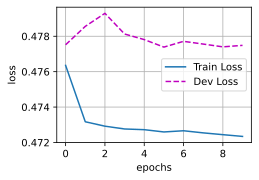